In [2]:
%matplotlib inline
import sys 
sys.path.append('..')
import matplotlib
import mglearn
import os

from preamble import *
#plt.rcParams['image.cmap'] = "gray"

from matplotlib.pyplot import rc
rc('font',family='New Gulim') #plot 한글폰트 적용

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

## 5.2 그리드 서치(Grid Search)

- 모델 매개변수 튜닝을 통한 일반화 성능 개선
- 가장 널리 사용되는 방법은 Grid Search (그리드 탐색)
    - 관심있는 매개변수들을 대상으로 모든 조합을 시도함

### 5.2.1 간단한 그리드 서치

In [4]:
# 간단한 그리드 서치 구현
from sklearn.svm import SVC

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("훈련 세트의 크기: {}   테스트 세트의 크기: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가합니다
        score = svm.score(X_test, y_test)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: {}".format(best_parameters))

훈련 세트의 크기: 112   테스트 세트의 크기: 38
최고 점수: 0.97
최적 파라미터: {'C': 100, 'gamma': 0.001}


In [5]:
svc = SVC(C=100,gamma=0.001)
svc.fit(X_train, y_train)
svm.score(X_test, y_test)

0.4473684210526316

- 위 0.97의 정확도는 전혀 새로운 데이터에 대한 성능으로 이어지지 않을 수 있다.
- 즉, 위 예제에서 사용한 테스트 데이터는 모델 구성시에 사용을 해버렸기 때문에 이 모델이 얼마나 좋은지 평가하는 데 더 이상 사용할 수 없다.


* 찾은 매개변수를 적용한 모델의 실제 정확도는 새로운 데이터를 통해 검증해야 된다,
    * 훈련, 테스트 데이터 이외의 데이터가 필요

### 5.2.2 매개변수 과대적합과 검증 세트

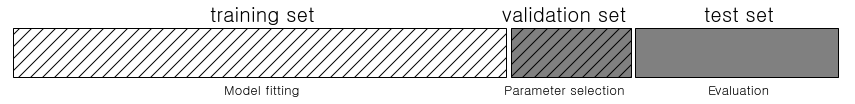

In [6]:
mglearn.plots.plot_threefold_split()

In [7]:
from sklearn.svm import SVC
# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("훈련 세트의 크기: {}   검증 세트의 크기: {}   테스트 세트의 크기:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 검증 세트로 SVC를 평가합니다
        score = svm.score(X_valid, y_valid)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후
# 테스트 세트를 사용해 평가합니다
svm = SVC(**best_parameters) #best_parameters = {'C':100, 'gamma':0.001} 
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: ", best_parameters)
print("최적 파라미터에서 테스트 세트 점수: {:.2f}".format(test_score))

훈련 세트의 크기: 84   검증 세트의 크기: 28   테스트 세트의 크기: 38

검증 세트에서 최고 점수: 0.96
최적 파라미터:  {'C': 10, 'gamma': 0.001}
최적 파라미터에서 테스트 세트 점수: 0.92


### 5.2.3 교차 검증을 사용한 그리드 서치

In [8]:
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {}, size of validation set: {},size of test set: {}\n".format(
    X_train.shape[0], 
    X_valid.shape[0], 
    X_test.shape[0]))

# reference: manual_grid_search_cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
#[NOTE] 훈련 데이터와 검증 데이터를 합쳐서 다시 모델을 구성함
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84, size of validation set: 28,size of test set: 38

Best score on validation set: 0.97
Best parameters:  {'C': 100, 'gamma': 0.01}
Test set score with best parameters: 0.97


- 위 예에서는 반복적인 모델 생성 작업이 6 x 6 x 5 = 180번 이루어짐
    - 즉, 시간이 많이 소요됨에 주의
- 아래 그림은 교차 검증에 5-fold 사용
- 매개변수 그리드는 일부만 표시
- 교차 검증 5번의 평균이 가장 높은 매개변수를 빨간 동그라미로 표시

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

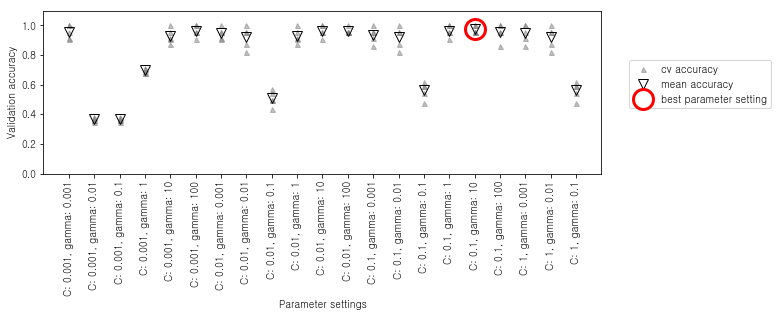

In [9]:
mglearn.plots.plot_cross_val_selection()

- 그리드 서치와 교차 검증을 사용한 매개 변수 선택과 모델 평가의 전체 작업 흐름
![process](./process.jpg)

- model_selection.GridSearchCV
    - **교차 검증을 사용하는 그리드 탐색을 통한 모델 파라미터 검색 기능 제공 객체**
    - 기본적으로 사용하는 교차 검증 분류기
        - 분류에는 StratifiedKFold 사용함
        - 회귀에는 KFold 사용함
    - fit을 수행한 이후에는 가장 최적의 파라미터로 만들어진 모델을 구성하고 있음.
- 다른 estimator (or 모델)를 사용하여 만들어지는 estimator를 메타 추정기(meta-estimator)라고 함.
    - GridSearchCV는 가장 널리 사용되는 메타 추정기
    - scikit-learn에서는 MetaEstimatorMixin 클래스를 상속한 모델을 메타 추정기라고 부름
        - 메타 추정기 예
            - GridSearchCV
            - RandomForest
            - GradientBoosting
            - RFE
            - ...

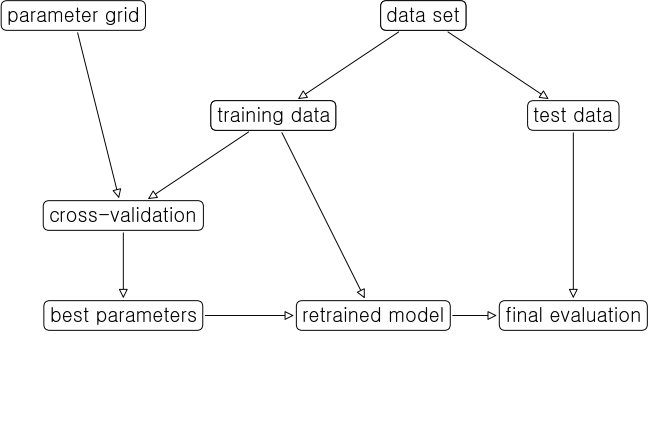

In [10]:
mglearn.plots.plot_grid_search_overview()

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("매개변수 그리드:\n{}".format(param_grid))

매개변수 그리드:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [23]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


In [25]:
print("최적 매개변수: {}".format(grid_search.best_params_))
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 매개변수: {'C': 100, 'gamma': 0.01}
최고 교차 검증 점수: 0.97


In [26]:
print("최고 성능 모델:\n{}".format(grid_search.best_estimator_))

최고 성능 모델:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
